In [1]:
# Change path drive log.csv to reflect AWS instance.
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys

def load_data(second_track=True, train=True):
    lines=[]
    if second_track==False:
        if train:
            logfile='C:/Users/omkar.karve/CarND-Behavioral-Cloning-P3-master/windows_sim/track1_drive_log_train.csv'
        else:
            logfile='C:/Users/omkar.karve/CarND-Behavioral-Cloning-P3-master/windows_sim/track1_drive_log_validate.csv'
    
    if second_track==True:
        if train:
            logfile='C:/Users/omkar.karve/CarND-Behavioral-Cloning-P3-master/windows_sim/track2_drive_log_train.csv'
        else:
            logfile='C:/Users/omkar.karve/CarND-Behavioral-Cloning-P3-master/windows_sim/track2_drive_log_validate.csv'

    with open(logfile) as csvfile:
        reader=csv.reader(csvfile)
        for line in reader:
            lines.append(line)

    image_files = []
    measurements = []
    X_train_files=[]
    steering_correction=0.25
    
    for line in lines:
        for i in range(3):
            sourcepath = line[i]
            filename = sourcepath.split('/')[-1]
            currentpath = 'C:/Users/omkar.karve/CarND-Behavioral-Cloning-P3-master/windows_sim/IMG/'+filename
            #image = cv2.imread(currentpath,1)
            #images.append(np.array(image))
            image_files.append(currentpath)
            measurement = float(line[3])
            if i==0:
                measurements.append(measurement)
            if i==1:
                measurements.append(measurement+steering_correction)
            if i==2:
                measurements.append(measurement-steering_correction)

             
    X_train_files = np.array(image_files)
    y_train = np.array(measurements)
    
    #print(X_train_files)
    #print(measurements)
    return X_train_files, y_train

In [2]:
# Source for transformations: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9

def flip_img(img, angle, prob=0.5):
    if  np.random.rand() < prob:
        img = np.fliplr(img)
        angle = - angle
    return img, angle

def brighten_img(img):
    image1 = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype=np.float64)
    random_bright = .5 + np.random.uniform()
    image1[:, :, 2] = image1[:, :, 2] * random_bright
    image1[:, :, 2][image1[:, :, 2] > 255] = 255
    image1 = np.array(image1, dtype=np.uint8)
    image1 = cv2.cvtColor(image1, cv2.COLOR_HSV2RGB)
    return image1

def shadow_add_img(img):
    top_y = 320 * np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320 * np.random.uniform()
    image_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    shadow_mask = 0 * image_hls[:, :, 1]
    X_m = np.mgrid[0:img.shape[0], 0:img.shape[1]][0]
    Y_m = np.mgrid[0:img.shape[0], 0:img.shape[1]][1]
    shadow_mask[((X_m - top_x) * (bot_y - top_y) - (bot_x - top_x) * (Y_m - top_y) >= 0)] = 1

    # random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2) == 1:
        random_bright = .5
        cond1 = shadow_mask == 1
        cond0 = shadow_mask == 0
        if np.random.randint(2) == 1:
            image_hls[:, :, 1][cond1] = image_hls[:, :, 1][cond1] * random_bright
        else:
            image_hls[:, :, 1][cond0] = image_hls[:, :, 1][cond0] * random_bright
    image = cv2.cvtColor(image_hls, cv2.COLOR_HLS2RGB)
    return image

def translate_img(image, angle, trans_range):
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    steer_ang = angle + tr_x / trans_range * 2 * .2
    # tr_y = 40 * np.random.uniform() - 40 / 2
    tr_y = 0
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    col, row = image.shape[:2]
    image_tr = cv2.warpAffine(image, Trans_M, (row, col))

    return image_tr, steer_ang

def augmented_image(img_file, angle):
    
    img=cv2.imread(img_file)
    #print(img_file)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img, angle = translate_img(img, angle,100)
    img=brighten_img(img)
    img=shadow_add_img(img)
    img=np.array(img)
    img, angle=flip_img(img, angle)
    
    return img, angle




In [3]:
# Generator code taken from following link and then modified
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html

def train_data_generator(X_train_file, y_train, batch_size=128, keep_prob=1.0, loop_forever=True,):
    
    sample_size=len(X_train_file)
    #print(X_train.shape)
    while 1:
        images=[]
        angles=[]
        
        for i in range(0,batch_size):
            rndm=np.random.randint(0, sample_size)
            rndm_sample=X_train_file[rndm]
            angle = y_train[rndm]
            img, angle = augmented_image(rndm_sample, angle)
            images.append(img)
            angles.append(angle)
            if len(angles) == batch_size:
                X_train_batch = np.array(images)
                y_train_batch = np.array(angles).squeeze()
                yield X_train_batch, y_train_batch
                images = []
                angles = []
        if not loop_forever: break

def validation_data_generator(X_valid, y_valid, batch_size=128, loop_forever=True,):
    sample_size=len(X_valid)
    while 1:
        images=[]
        angles=[]
        
        for i in range(0,batch_size):
            img_file = X_valid[i]
            angle = y_valid[i]
            img=cv2.imread(img_file)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            images.append(img)
            angles.append(angle)
            if len(angles) == batch_size:
                X_valid_batch = np.array(images)
                y_valid_batch = np.array(angles).squeeze()
                yield X_valid_batch, y_valid_batch
                images = []
                angles = []
        if not loop_forever: break

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Cropping2D

def NvidiaNet(input_shape, dropout = .3):
    """
    Implement the Nvidia model for self driving cars
    https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
    :param input_shape: shape of the images (r,w,c)
    :param dropout: 
    :return: 
    """

    model = Sequential()

    # normalization
    model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=input_shape))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))

    # Allow the model to choose the appropriate color space
    # https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9
    model.add(Conv2D(3, kernel_size=(1, 1), strides=(1, 1), activation='linear'))

    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='relu'))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='relu'))

    model.add(Dense(1, activation='linear'))

    return model

C:\Users\omkar.karve\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# Full pipeline
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
#from models import LeNetKerasMSE, Simple, NvidiaNet
#from data_pipe import *
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

savedmodelname = 'model.h5'
row, col, ch = 160, 320, 3
batch_size = 256
keep_prob = .9
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
X_train_file, y_train = load_data(second_track=False, train=True)
X_valid_file, y_valid = load_data(second_track=False, train=False)
print("starting")

model = NvidiaNet((row,col,ch), dropout=.3)

model.compile(loss='mse', optimizer='adam')

steps_per_epoch = len(X_train_file) // batch_size
validation_steps = len(X_valid_file) // batch_size

print('Number of training steps {}'.format(steps_per_epoch))
print('Number of validation steps {}'.format(validation_steps))
generator_train = train_data_generator(X_train_file, y_train, batch_size, keep_prob)
generator_valid = validation_data_generator(X_valid_file, y_valid, batch_size)
history_object = model.fit_generator(generator_train,
                                     steps_per_epoch=steps_per_epoch,
                                     validation_data=generator_valid,
                                     validation_steps=validation_steps,
                                     epochs=2,
                                     callbacks=[early_stopping],
                                     verbose = 1
                                     )
'''    
for i in range(2):
    generator_train = train_data_generator(X_train_file, y_train, batch_size, keep_prob)
    #generator_valid = validation_data_generator(X_valid_file, y_valid, batch_size)
    history_object = model.fit_generator(generator_train,
                                         samples_per_epoch=len(X_train_file),
                                         epochs=1,
                                         verbose = 1
                                         )
'''
print('Saving model to {}'.format(savedmodelname))
model.save(savedmodelname)

starting
Number of training steps 80
Number of validation steps 20
Epoch 1/2
80/80 [==============================] - 558s 7s/step - loss: 0.0811 - val_loss: 0.0401
Epoch 2/2
80/80 [==============================] - 600s 7s/step - loss: 0.0646 - val_loss: 0.0323
Saving model to model.h5


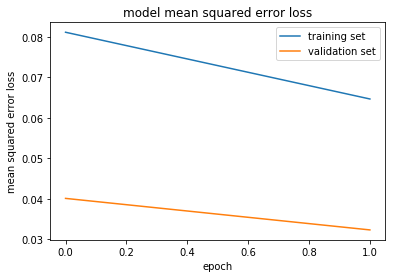

In [7]:
# Saving the learning curve
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('learning_curve.png')